# **Project 1: Exam notes prediction based on stress physiological variables**

The objective of this project is to analyze physiological data recorded during three exams on 10 different students. In this case, there is an `StudentGrades.txt` file that has all the grades of the students. Also it is possible to access to the data of the students in the `Data` folder. 

Each student is classified with a code starting with "S" and an assigned number from 1 to 10. 

For the purposes of this study, the variables that are going to be taken into account are:
* EDA: Electrodermal Activity (microSiemens)
* TEMP: Temperature (°C)
* BVP: Photoplethysmography

More info on `readme.md` and `info.txt` (directly on students folders).

# Import libraries

In [1]:
import os
from zipfile import ZipFile
from typing import Dict, List, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy import signal
from datetime import datetime

# Unzipping files

In [2]:
main_file_name = 'a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0.zip'
sub_file_name = 'Data.zip'

# New directory
path = main_file_name[:-4]
full_path = os.path.join(path, sub_file_name)

In [237]:
def zip_extraction(file_name: str, extract_dir: str = None) -> None:
    """
    Extract the zip file in `file_name` into the directory `extract_dir`.
    
    param file_name: Zip file that is going to be extracted. 
    param extract_dir: Directory in which `file_name` will be extracted. By default, it's value is None, what means it is
        going to be extracted on the current path. 
    """
    with ZipFile(file_name, 'r') as zip:
        zip.printdir()
        print('Extrayendo archivos')
        zip.extractall(path=extract_dir)
        print('Finalizado')

In [238]:
# zip_extraction(main_file_name) # Extracting main zip
# zip_extraction(full_path, path) # Extracting zip with students data contained. 

# File reading

## Reading physiological data

In [3]:
# Define column names for each variable
default_variables = {'ACC': ['x', 'y', 'z'], 
                    '': ['BVP'], 
                    'EDA': ['EDA'], 
                    'HR': ['HR'], 
                    'IBI':['Time', 'Interval duration'], 
                    'TEMP':['TEMP']
                   }

# Definining my variables
physio_variables = {key: value for key, value in default_variables.items() if key in ('EDA', 'BVP', 'TEMP')}

# Define types of exam
exam_list = ['Midterm 1', 'Midterm 2', 'Final']

# Define students list
students_list = [f'S{i}' for i in range(1, 11)]

In [4]:
# Generate a dictionary with all the information required per student. 
students_dict = {}

# Generate a dictionary with information related to time (Unix timestamp) and sampling rate. 
time_freq_dict = {} 

for student in students_list: # Loop over each student
    students_dict[student], time_freq_dict[student] = {}, {}
    for exam in exam_list: # Loop over each type of exam in `exam_list`
        students_dict[student][exam], time_freq_dict[student][exam] = {}, {}
        for physio_var, values in physio_variables.items(): # Loop over each physiological variable
            read_data = pd.read_csv(f'a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-'\
                                    f'in-real-world-settings-1.0.0/Data/{student}/{exam}/{physio_var}.csv', 
                                    names=values,
                                    )
            time_freq_dict[student][exam][physio_var] = read_data.loc[0:1, :]
            time_freq_dict[student][exam][physio_var].index = ['Initial time (Unix)', 'Sampling rate']
            students_dict[student][exam][physio_var] = read_data.loc[2:, :] 

In [5]:
print(students_dict.keys())
print(students_dict['S1'].keys())
print(students_dict['S1']['Midterm 1'].keys())
print(students_dict['S1']['Midterm 1']['BVP'].keys())

dict_keys(['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10'])
dict_keys(['Midterm 1', 'Midterm 2', 'Final'])
dict_keys(['BVP', 'EDA', 'TEMP'])
Index(['BVP'], dtype='object')


## Reading grades data

In [6]:
# Reading Student Grades data
grades_path = os.path.join(path, 'StudentGrades.txt')

# Issues due to 'UTF-8' encoding. Was necessary to change data encoding. 
total_grades = pd.read_csv(grades_path, encoding='ISO-8859-1', names=['TOTAL GRADES'])

display(total_grades.head(15))

,TOTAL GRADES
0,GRADES - MIDTERM 1
1,------------------
2,S01  78
3,S02  82
4,S03  77
5,S04  75
6,S05  67
7,S06  71
8,S07  64
9,S08  92


In [7]:
# Identify '-----' rows
hyphen_rows = total_grades['TOTAL GRADES'].apply(lambda x: '--' in x)
# Find rows with a column name value
column_rows = total_grades['TOTAL GRADES'].apply(lambda x: 'GRADES' in x)
# Filter rows without hyphen and rename rows with column names
total_grades = total_grades[~hyphen_rows]
exam_label = total_grades['TOTAL GRADES'][column_rows].apply(lambda x: x[9:])

# Generate new DataFrame with each exam as a column
# apply() function is removing student code and the not working separator by leaving only last three digits of data.
exam_data = pd.DataFrame({exam_type: total_grades.loc[index + 2:index + 11, 
                                                      'TOTAL GRADES'].apply(lambda x: int(x[-3:])).values
             for index, exam_type in exam_label.items()}, 
             index=students_list)

exam_data.rename(columns={'MIDTERM 1': exam_list[0],
                          'MIDTERM 2': exam_list[1],
                          'FINAL (OUT OF 200)': exam_list[2]}, inplace=True)

display(exam_data)
display(exam_data.describe(include='all'))

,Midterm 1,Midterm 2,Final
S1,78,82,182
S2,82,85,180
S3,77,90,188
S4,75,77,149
S5,67,77,157
S6,71,64,175
S7,64,33,110
S8,92,88,184
S9,80,39,126
S10,89,64,116


,Midterm 1,Midterm 2,Final
count,10.000000,10.000000,10.000000
mean,77.500000,69.900000,156.700000
std,8.885069,19.980268,29.966834
min,64.000000,33.000000,110.000000
25%,72.000000,64.000000,131.750000
50%,77.500000,77.000000,166.000000
75%,81.500000,84.250000,181.500000
max,92.000000,90.000000,188.000000


# Data cleaning

## Generating a dictionary per physiological variable

In [8]:
def extract_physio_dict(physio_var: str, students_list: List[str], exam_list: List[str], 
                              students_info: Dict[str, Dict]) -> Dict[str, np.array]:
    """
    Generate a new dictionary with all the registered data of the same physiological value. Each column is the signal values
    for each student and the specific exam. 
    
    param physio_var: Variable from which the total DataFrame will be generated.
    param students_list: List of students that will be included in columns of DataFrame.
    param exam_list: List of types of exam that will be included in columns of DataFrame.
    param student_info: Dictionary from which physiological information will be extracted. 
    return: Dictionary with the values of the same variable. The new columns will be generated with the name 
        "`physio_var`+`exam`" where `exam` is the specific type of exam.
    """
    new_data = {f'{student} + {exam}': students_info[student][exam][physio_var].values.flatten() 
                for student in students_list for exam in exam_list}
    return new_data

In [9]:
eda_data = extract_physio_dict('EDA', students_list, exam_list, students_dict)
temperature = extract_physio_dict('TEMP', students_list, exam_list, students_dict)
bvp_data = extract_physio_dict('BVP', students_list, exam_list, students_dict)

In [10]:
# Saving all the information of the same variable
print(eda_data.keys())
print(eda_data['S1 + Midterm 1'])

dict_keys(['S1 + Midterm 1', 'S1 + Midterm 2', 'S1 + Final', 'S2 + Midterm 1', 'S2 + Midterm 2', 'S2 + Final', 'S3 + Midterm 1', 'S3 + Midterm 2', 'S3 + Final', 'S4 + Midterm 1', 'S4 + Midterm 2', 'S4 + Final', 'S5 + Midterm 1', 'S5 + Midterm 2', 'S5 + Final', 'S6 + Midterm 1', 'S6 + Midterm 2', 'S6 + Final', 'S7 + Midterm 1', 'S7 + Midterm 2', 'S7 + Final', 'S8 + Midterm 1', 'S8 + Midterm 2', 'S8 + Final', 'S9 + Midterm 1', 'S9 + Midterm 2', 'S9 + Final', 'S10 + Midterm 1', 'S10 + Midterm 2', 'S10 + Final'])
[0.       0.002563 0.019221 ... 0.024347 0.025628 0.024347]


## First data visualization

In [11]:
def general_visualization(students_info: Dict, student_code: str, exam: str, physio_variables: Dict, show_grades = True) -> None:
    """
    Generates a visualization of all the raw data recorded for student `student_code` for specific exam `exam`. 
    It generates a Matplotlib subplot based on the `physio_variables` dictionary. 

    param student_code: ID of the student.
    param exam: Exam from which the different variables will be plotted. 
    param physio_variables: Dictionary of physiological variables of interest. 
    param show_grades: If True, it shows also the bar plot of the scores of the student in all the exams (not only 
        in `exam`.)
    """
    n_plot = len(students_info[student_code][exam])
    list_variables = list(physio_variables.keys())
    exam_info = students_dict[student_code][exam]

    if show_grades:
        fig, ax = plt.subplots(n_plot + 1, 1)
    else:
        fig, ax = plt.subplots(n_plot, 1)
    
    
    fig.suptitle(f'General view for {student_code}. Exam: {exam}', y=3.7)
    plt.subplots_adjust(top=3.5)
    
    for index_plot in range(n_plot):
        sampling_rate = int(time_freq_dict[student_code][exam][list_variables[index_plot]].loc['Sampling rate', :])
        t = np.arange(0, len(exam_info[list_variables[index_plot]])) / sampling_rate
        ax[index_plot].set_title(f'{list_variables[index_plot]}')
        ax[index_plot].plot(t, exam_info[list_variables[index_plot]], color='k')
        ax[index_plot].set_xlabel('Time (seconds)')
    
    if show_grades:
        ax[index_plot + 1].set_title('Grades')
        ax[index_plot + 1].bar(np.arange(2), np.array([exam_data.loc[student_code, exam], 
                                                      exam_data.describe().loc['mean', exam]]),
                               edgecolor='black', color=['orange', 'green'])
        ax[index_plot + 1].set_xticks(np.arange(2))
        ax[index_plot + 1].set_xticklabels([student_code, 'Mean'])

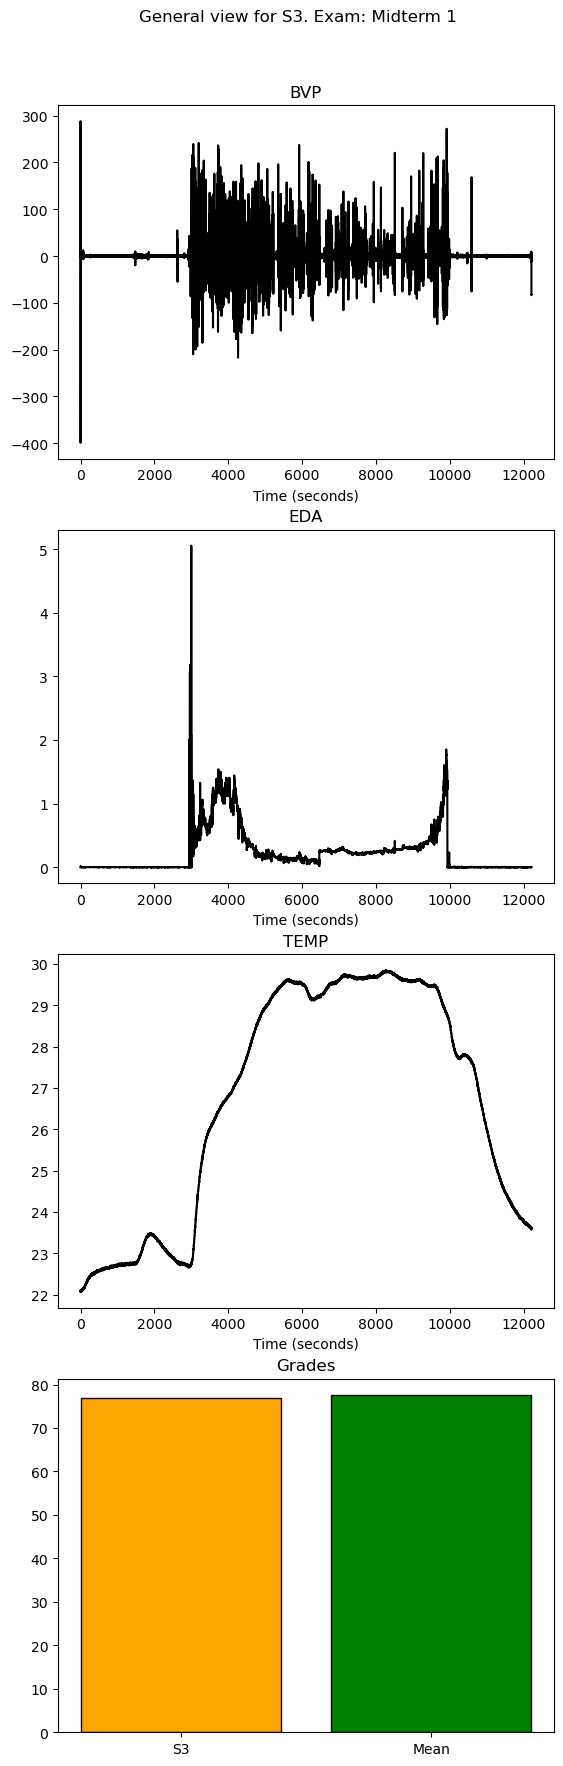

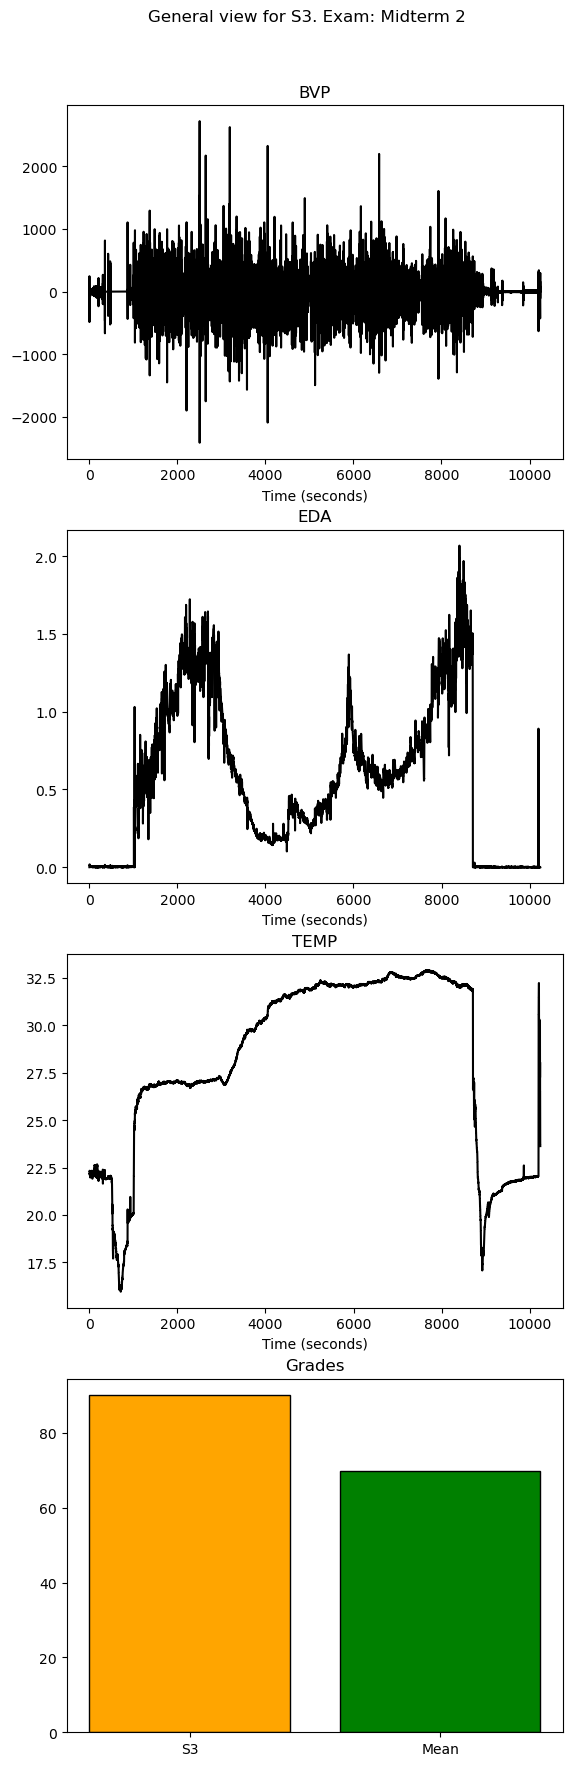

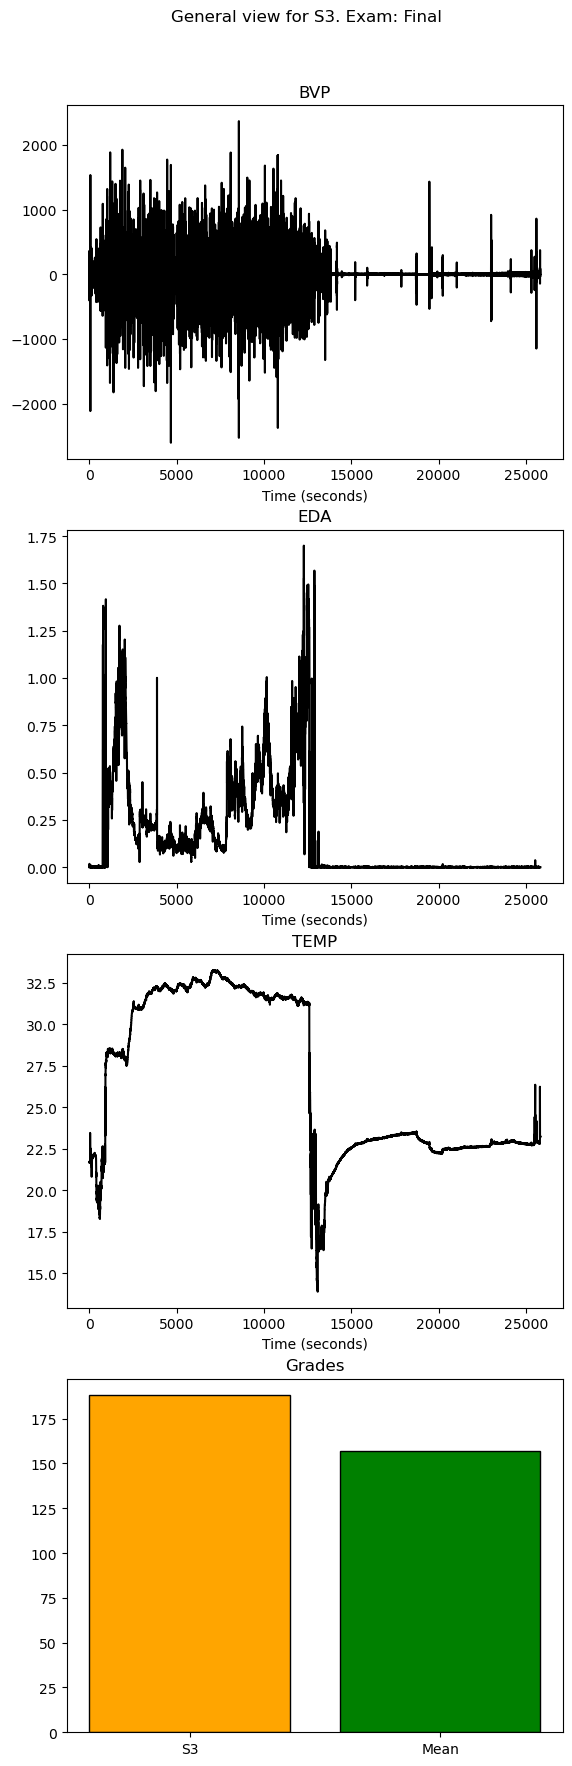

In [12]:
general_visualization(students_dict, 'S3', 'Midterm 1', physio_variables)
general_visualization(students_dict, 'S3', 'Midterm 2', physio_variables)
general_visualization(students_dict, 'S3', 'Final', physio_variables)

# Data Wrangling

After visualizing the recording of the data, it is possible to realize that the first and last local maximums on EDA signal show the relevant recording, so, the data that is going to be taken into account will be into this range. All the data out of this range, it's basically noise. 

In [42]:
def sampling_rate_time_vector(time_freq: Dict, student: str, exam: str,
                              variable: str, signal: np.array) -> Union[np.array, float]:
    """
    Calculate sampling rate time vector based on student, exam, physiological variable. 
    """
    sampling_rate = time_freq[student][exam][variable].loc['Sampling rate', :][0]
    time_vector = np.arange(0, len(signal)) / sampling_rate
    return time_vector, sampling_rate

In [199]:
def cut_boundaries(student: str, exam: str, plot_boundaries: bool = False, percentile: float = 80) -> np.array:
    """
    Compute boundaries based on percentile of EDA in order to eliminate noise at the beginning and at the end of each 
    of the signals. Generate a new dictionary with numpy array with both time (calculated based on sampling rate)
    and the cutted signal. 

    param student: Student's code. 
    param exam: Type of exam. 
    param plot_boundaries: If True, generates a plot of the boundaries of the signal
    param percentile: Threshold value based on percentile of the signal. By default, it's 80. 
    """
    # Generate data
    eda_signal = eda_data[f'{student} + {exam}']
    temp_signal = temperature[f'{student} + {exam}']
    bvp_signal = bvp_data[f'{student} + {exam}']

    # Define threshold
    threshold = np.percentile(eda_signal, percentile)
    over_thresh = np.where(eda_signal > threshold)[0]
    low_bound, sup_bound = over_thresh[0], over_thresh[-1]

    t_eda, sampling_rate_eda = sampling_rate_time_vector(time_freq_dict, student, exam, 'EDA', eda_signal)
    t_temp, _ = sampling_rate_time_vector(time_freq_dict, student, exam, 'TEMP', temp_signal)
    t_bvp, _ = sampling_rate_time_vector(time_freq_dict, student, exam, 'BVP', bvp_signal)

    # Adjust threshold to sampling rate for plotting
    sampling_low_bound, sampling_sup_bound = int(low_bound // sampling_rate_eda), int(sup_bound // sampling_rate_eda)

    # Generating new times and signals
    new_eda_time = t_eda[low_bound:sup_bound]
    new_eda_signal = eda_signal[low_bound:sup_bound]

    # Temperature data
    temp_inf_time, temp_sup_time = (int(np.where(t_temp == sampling_low_bound)[0]), 
                                    int(np.where(t_temp == sampling_sup_bound)[0]))
    new_temp_time = t_temp[temp_inf_time:temp_sup_time]
    new_temp_signal = temp_signal[temp_inf_time:temp_sup_time]

    # BVP Data
    bvp_inf_time, bvp_sup_time = (int(np.where(t_bvp == sampling_low_bound)[0]), 
                                    int(np.where(t_bvp == sampling_sup_bound)[0]))
    new_bvp_time = t_bvp[bvp_inf_time:bvp_sup_time]
    new_bvp_signal = bvp_signal[bvp_inf_time:bvp_sup_time]

    
    if plot_boundaries:
        fig, ax = plt.subplots(nrows=3, ncols=2)
        fig.tight_layout(pad=2)

        ax[0, 0].set_title(f'{student}: {exam}. Original')
        ax[0, 0].plot(t_eda, eda_signal, 'k', label='Original signal')
        ax[0, 0].plot([sampling_low_bound, sampling_low_bound], [0, max(eda_signal)], '--', label='Low boundary')
        ax[0, 0].plot([sampling_sup_bound, sampling_sup_bound], [0, max(eda_signal)], '--', label='High boundary')
        ax[0, 0].plot([0, t_eda[-1]], [threshold, threshold], 'r--', label=f'Threshold: {np.round(threshold, 3)}')
        ax[0, 0].legend(fontsize='5')
        ax[0, 0].set_xlabel('Time (s)')
        ax[0, 0].set_ylabel('Conductance (uS)')
        

        ax[0, 1].plot(new_eda_time, new_eda_signal, 'k')
        ax[0, 1].set_xlabel('Time (s)')
        ax[0, 1].set_ylabel('Conductance (uS)')

        ax[0, 1].set_title(f'{student}: {exam}. New signal')

        ax[1, 0].plot(t_temp, temp_signal, 'k')
        ax[1, 0].plot([sampling_low_bound, sampling_low_bound], [min(temp_signal), max(temp_signal)], 
                   '--', label='Low boundary')
        ax[1, 0].plot([sampling_sup_bound, sampling_sup_bound], [min(temp_signal), max(temp_signal)], 
                   '--', label='High boundary')
        ax[1, 0].set_xlabel('Time (s)')
        ax[1, 0].set_ylabel('Temperature (°C)')
        
        ax[1, 1].plot(new_temp_time, new_temp_signal, 'k')        
        ax[1, 1].set_xlabel('Time (s)')
        ax[1, 1].set_ylabel('Temperature (°C)')

        ax[2, 0].plot(t_bvp, bvp_signal, 'k')
        ax[2, 0].plot([sampling_low_bound, sampling_low_bound], [min(bvp_signal), max(bvp_signal)], 
                   '--', label='Low boundary')
        ax[2, 0].plot([sampling_sup_bound, sampling_sup_bound], [min(bvp_signal), max(bvp_signal)], 
                   '--', label='High boundary')
        ax[2, 0].set_xlabel('Time (s)')
        ax[2, 0].set_ylabel('BVP (a. u.)')
        
        ax[2, 1].plot(new_bvp_time, new_bvp_signal, 'k')
        ax[2, 1].set_xlabel('Time (s)')
        ax[2, 1].set_ylabel('BVP (a. u.)')
        plt.show()
        


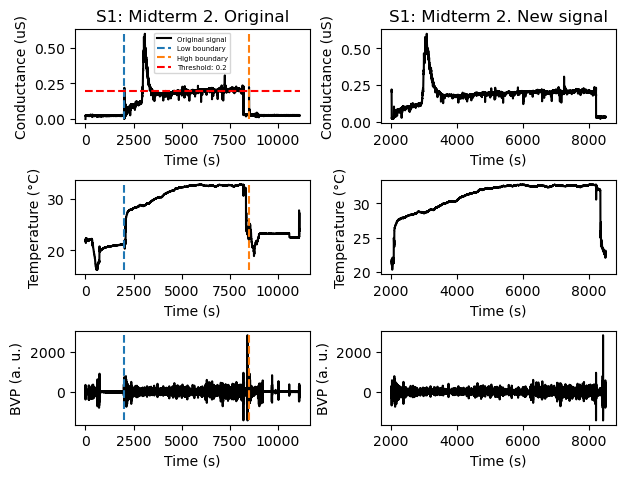

In [200]:
a = cut_boundaries('S1', 'Midterm 2', True)

# Ya tengos los límites superior e inferior de la EDA
# Ya tengo la señal cortada de EDA
# Ya agarré los límites que definí para cortar la señal de EDA en el tiempo y los convertí a la frecuencia de
# muestreo de la temperatura
# Necesito es saber cuál es el índice del vector de tiempo en la posición en la que se ubica el límite.
